# Analysis CVC in noise CVC_Sbcd65_Nfront65

30 January 2021 Guido Cattani, Revision 13 June 2022

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import mannwhitneyu as mannwhitneyu
from scipy.stats import wilcoxon as wilcoxon
from scipy.stats import rankdata as rankdata
from scipy.stats import shapiro as shapiro
from scipy.stats import ttest_rel as ttest_rel
from scipy.stats import ttest_ind as ttest_ind
from scipy.stats import levene as levene

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def select_bp110(df):
    # select BP110 data
    is_bp110 =  df['Device']=='BP110'
    df_bp110 = df[is_bp110]
    df_bp110.pop('Device')
    return(df_bp110)

In [5]:
def select_bh5(df):
    # select BAHA5P data
    is_baha5p =  df['Device']=='BAHA5P'
    df_baha5p = df[is_baha5p]
    df_baha5p.pop('Device')
    return(df_baha5p)

In [6]:
def read_CVC():
    f_in =  '/media/guido/LACIE/Cingle_Guido/Master/Headband/CVC_Sbcd65_Nfront65.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='CVC_Sbcd65_Nfront65', header=0, nrows=85)
    df = df.drop(['Unnamed: 0', 'Study_ID'], axis=1)
    return df

In [7]:
cvc = read_CVC()
cvc

,Device,AC_path,BC_path,AC&BC_path,diff_combi_AC
0,BP110,0.74,0.74,0.74,0.00
1,BP110,0.73,0.76,0.76,0.03
2,BP110,0.74,0.75,0.78,0.04
3,BP110,0.74,0.72,0.75,0.01
4,BP110,0.74,0.72,0.74,0.00
...,...,...,...,...,...
65,BAHA5P,0.74,0.79,0.76,0.02
66,BAHA5P,0.74,0.84,0.74,0.00
67,BAHA5P,0.74,0.84,0.77,0.03
68,BAHA5P,0.73,0.81,0.77,0.04


In [8]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc = cvc.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc.quantile(q=quantiles)

In [9]:
q= q.round(decimals=4)
q = q.reset_index()
diq = {0:'BAHA5P P10', 1:'BAHA5P P50', 2:'BAHA5P P90', 
      3:'BP110 P10', 4:'BP110 P50', 5:'BP110 P90'} 

q = q.rename(index=diq)
q.drop(['Device', 'level_1'], axis=1, inplace = True)
q

,AC_path,BC_path,AC&BC_path,diff_combi_AC
BAHA5P P10,0.73,0.81,0.740,0.00
BAHA5P P50,0.74,0.83,0.760,0.02
BAHA5P P90,0.74,0.85,0.790,0.05
BP110 P10,0.73,0.71,0.740,0.00
BP110 P50,0.74,0.75,0.750,0.01
BP110 P90,0.74,0.79,0.786,0.05


In [10]:
cvc_bp110 = select_bp110(cvc)
cvc_bh5 = select_bh5(cvc)
len(cvc_bp110), len(cvc_bh5)

(35, 35)

In [11]:
bh5 = cvc_bh5.T.to_numpy()
bp110 = cvc_bp110.T.to_numpy()

In [12]:
# check normality output group BAHA5P & BP110 with Shapiro-Wilk test

shp = dict()

for i in range(0, 4):
    a = bh5[i]
    b = bp110[i]
    shapiro_stat_bh5, pVal_bh5 = shapiro(a) # bh5 scipy.stats Shapiro-Wilk test test
    shapiro_stat_bp110, pVal_bp110 = shapiro(b) # bp110 scipy.stats Shapiro-Wilk test test
    bh5_is_normal = False if pVal_bh5 < 0.05 else True
    bp110_is_normal = False if pVal_bp110 < 0.05 else True
    st = {i: [shapiro_stat_bh5, pVal_bh5, bh5_is_normal, shapiro_stat_bp110, pVal_bp110, bp110_is_normal]}
    shp.update(st)

shapiro_test = pd.DataFrame.from_dict(shp)
dish =  {0: 'Shapiro test statistic BH5', 1: 'p-value BH5', 2: 'normally distributed in BH5', 3: 'Shapiro test statistic BP110', 
         4: 'p-value BP110', 5: 'normally distributed in BP110'}
clmns = {0 : 'AC_path', 1 : 'BC_path', 2 : 'AC&BC_path', 3 : 'diff_combi_AC'}
shapiro_test.rename(index=dish, columns = clmns, inplace = True)

shapiro_test

,AC_path,BC_path,AC&BC_path,diff_combi_AC
Shapiro test statistic BH5,0.418064,0.938853,0.834739,0.819204
p-value BH5,0.0,0.051638,0.000106,0.00005
normally distributed in BH5,False,True,False,False
Shapiro test statistic BP110,0.600757,0.975463,0.8064,0.80705
p-value BP110,0.0,0.609049,0.000027,0.000028
normally distributed in BP110,False,True,False,False


In [13]:
# Levene test for equal variances CVC-score bc_path bp110 vs. bh5 groups
levene(bp110[1], bh5[1])

LeveneResult(statistic=18.864636830520986, pvalue=4.788962529550471e-05)

In [14]:
#Welch’s t-test (which does not assume equal population variance) SII bcd_path bp110 vs. bh5 groups
ttest_ind(bp110[1], bh5[1], equal_var=False)

Ttest_indResult(statistic=-13.185672395510906, pvalue=1.4565129332268894e-17)

In [15]:
d1 = dict()
d2 = dict()
for i in range(0, 4):
    (stat, pvalue) = mannwhitneyu(bp110[i], bh5[i], use_continuity=False, alternative='two-sided')
    d1.update({i : stat})
    d2.update({i : pvalue})

In [16]:
mwu = pd.DataFrame.from_dict([d1, d2])
rws = {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
clmns = {0 : 'AC_path', 1 : 'BC_path', 2 : 'AC&BC_path', 3 : 'diff_combi_AC'}
mwu.rename(index = rws, columns = clmns, inplace = True)
mwu = mwu.round(decimals=4)
mwu

,AC_path,BC_path,AC&BC_path,diff_combi_AC
Mann-Whitney U statistic,490.0000,18.5,492.5000,538.5000
p-value (two-sided),0.0527,0.0,0.1461,0.3716


In [17]:
d2 # p van U test

{0: 0.05272867867424474,
 1: 2.4830707087839144e-12,
 2: 0.14613982244613857,
 3: 0.3716301492181887}

In [18]:
# Wilcoxon signed-rank
w_bp110 = wilcoxon(bp110[3])
w_bp110

WilcoxonResult(statistic=0.0, pvalue=8.378218840902654e-05)

In [19]:
w_bh5 = wilcoxon(bh5[3])
w_bh5

WilcoxonResult(statistic=0.0, pvalue=1.1393204577192098e-05)

In [20]:
# make dataframe with results wilcoxon
dwx = {'BAHA5P P50': [w_bh5[0], w_bh5[1]], 'BP110 P50' : [w_bp110[0], w_bp110[1]]} 
dfx = pd.DataFrame.from_dict(dwx, orient = 'index', columns = ['Wilcoxon s-r test diff_combi_AC', 'p-value (2s)'])
dfx 

,Wilcoxon s-r test diff_combi_AC,p-value (2s)
BAHA5P P50,0.0,0.000011
BP110 P50,0.0,0.000084


In [21]:
# make dataframe with all results
analysis_output = pd.concat([q, mwu])
analysis_output = pd.concat([analysis_output, dfx], axis = 1)
analysis_output

,AC_path,BC_path,AC&BC_path,diff_combi_AC,Wilcoxon s-r test diff_combi_AC,p-value (2s)
BAHA5P P10,0.7300,0.81,0.7400,0.0000,NaN,NaN
BAHA5P P50,0.7400,0.83,0.7600,0.0200,0.0,0.000011
BAHA5P P90,0.7400,0.85,0.7900,0.0500,NaN,NaN
BP110 P10,0.7300,0.71,0.7400,0.0000,NaN,NaN
BP110 P50,0.7400,0.75,0.7500,0.0100,0.0,0.000084
BP110 P90,0.7400,0.79,0.7860,0.0500,NaN,NaN
Mann-Whitney U statistic,490.0000,18.50,492.5000,538.5000,NaN,NaN
p-value (two-sided),0.0527,0.00,0.1461,0.3716,NaN,NaN


In [22]:
# write to xlsx file
analysis_output.to_excel("/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/analysis_CVC_Sbcd65_Nfront65.xlsx",
                         sheet_name='CVC_Sbcd65_Nfront65')  

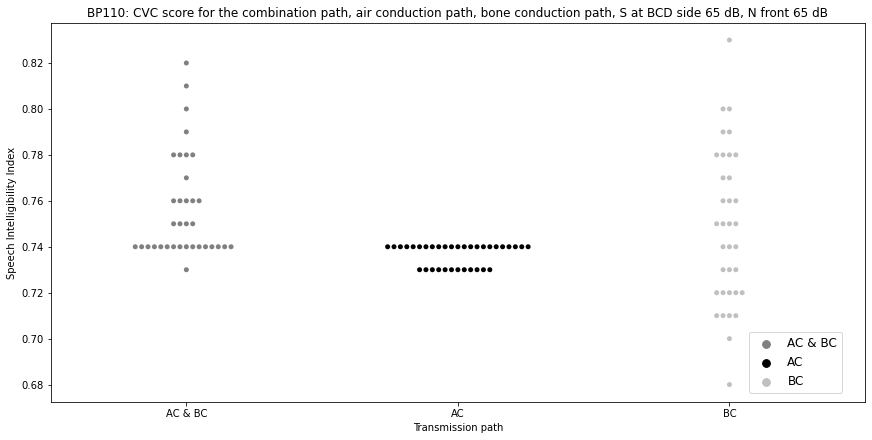

In [23]:
# make a figure to plot CVC score for the 3 paths
ttl = 'BP110: CVC score for the combination path, air conduction path, bone conduction path, S at BCD side 65 dB, N front 65 dB'
cvc_combi = cvc_bp110['AC&BC_path']
cvc_ac = cvc_bp110['AC_path']
cvc_bc = cvc_bp110['BC_path']
tp = pd.melt(pd.DataFrame( {'AC & BC' : cvc_combi, 'AC' : cvc_ac, 'BC' : cvc_bc }), 
             var_name = 'Transmission path', value_name = 'Speech Intelligibility Index') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.swarmplot(data = tp, x = 'Transmission path', y = 'Speech Intelligibility Index', 
              hue = 'Transmission path', size=5, palette={'silver', 'grey', 'black'})

ax.set_title(ttl)
plt.legend(bbox_to_anchor=(0.85, 0.2), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/BP110_CVC_Sbcd65_Nfront65.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")


plt.show()

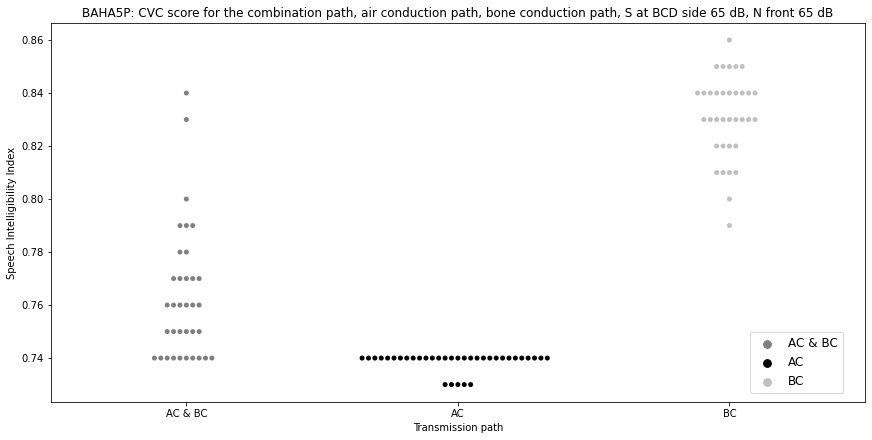

In [24]:
# make a figure to plot CVC score for the 3 paths
ttl = 'BAHA5P: CVC score for the combination path, air conduction path, bone conduction path, S at BCD side 65 dB, N front 65 dB'
cvc_combi = cvc_bh5['AC&BC_path']
cvc_ac = cvc_bh5['AC_path']
cvc_bc = cvc_bh5['BC_path']
tp = pd.melt(pd.DataFrame( {'AC & BC' : cvc_combi, 'AC' : cvc_ac, 'BC' : cvc_bc }), 
             var_name = 'Transmission path', value_name = 'Speech Intelligibility Index') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.swarmplot(data = tp, x = 'Transmission path', y = 'Speech Intelligibility Index', 
              hue = 'Transmission path', size=5, palette={'silver', 'grey', 'black'})

ax.set_title(ttl)
plt.legend(bbox_to_anchor=(0.98, 0.2), fontsize='large')

# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/BAHA5P_CVC_Sbcd65_Nfront65.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show()